<img src="https://www.globallogic.com/de/wp-content/uploads/sites/26/2019/10/Machine-Learning.jpg">

<br><br>

<H2><B> Cómputo cognitivo con aprendizaje profundo aplicado a la música</B></H2>
<br><br>
<H3><I> Ismael Medina Muñoz </I></H3>

---

# Planteamiento del problema
La creación artística está siendo impactada por la inteligencia artificial. La música no es un campo ajeno a dicho impacto. La creación musical es un proceso que toma tiempo para el compositor. En un contexto de creación de obras artísticas usadas en productos como comerciales de productos, videojuegos, contenido audiovisual en internet, etc. se requiere de la producción acelerada.
Esta actividad de creación musical ha sido una actividad atribuida meramente a los humanos, tal cómo lo establece Morán Martinez, M (2009).

    La creación, la ejecución y la apreciación de la música obedecen fundamentalmente a la capacidad humana para descubrir patrones de sonido e identificarlos en ocasiones posteriores. Sin los procesos biológicos de percepción auditiva y sin consenso cultural sobre lo percibido, entre por lo menos algunos oyentes, no pueden existir ni música ni comunicación musical.

Si bien existen ya muchas investigaciones sobre la composición musical automatizada, la creación asistida e interactiva para los compositores es aún un reto para la investigación, tal como menciona Briot, J. (2021).

Para componer música necesitamos entonces de un generador de nuevas notas singulares o acordes basado en secuencias existentes y coherentes que ya sean parte de un corpus de entrenamiento.

En este experimento se entrenará una red neuronal profunda para que sea un generador de nuevas notas o acordes a partir de dos vectores que representen una nota o un acorde inicial. Este generador será un precursor a la asistencia en la composición de piezas de jazz para piano. Se escogió el género del jazz dado que éste representa un reto para los músicos por su complejidad y riqueza lingüística.

# Metodología propuesta y fundamentación
La composición musical consiste de crear secuencias de $n$-notas con $n = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}$, donde también es posible registrar el silencio por $0$-notas y describir acordes de $2$-notas o más. Las $n$-notas ejecutadas en una secuencia $S$ deben ser agradables el oído humano. Las partituras permiten registrar la música a través de escribir las $n$-notas colocadas en relación a su posición relativa en una secuencia $S$ dentro de los límites de un compás. Cada conjunto de $n$-notas tienen una duración que se mantienen bajo las reglas y límites propios de los compases.

La música es precursor del lenguaje hablado y por tanto mantiene una similitud con ésta, tal como establece Lozano(2013). Una oración sólo tiene coherencia si las palabras que la forman resultan en un significado para el receptor de la comunicación. Las oraciones forman párrafos y los signos de puntuación permiten agregar pausas y entonaciones que ayudan a que el cerebro del receptor consuma la información que el emisor pretendía.

Se escogió una fuente digital de partituras para modelar la secuencia $S$ de $n$-notas. El corpus provino entonces de [musescore.com]. Desde este sitio se descargaron las partituras en formato **MSCZ** pertenecientes al género del jazz y de ahí se propone hacer la extracción de las $n$-notas asociadas al piano, ya que dichas partituras pueden tener más de un instrumento descrito en sus pentagramas.

Mediante la librería `ms3` se abrirán las partituras y de ellas se obtendrán las secuencias de $n$-notas asociadas al piano. con dichas notas se generarán secuencias de acordes y estas secuencias serán usadas para entrenar la red neuronal que predecirá el siguiente acorde de $n$-notas en la secuencia. Este generador será el antecedente para la composición musical.

Este trabajo es similar al que ya se aplica para predecir la siguiente palabra o el siguiente número dada una secuencia previa y que ha sido modelado usando redes neuronales recurrentes (RNN). 

# Implementación de la metodología
## Carga de librerías y las rutas del corpus

In [1]:
from ms3 import Score, Parse
import ms3
import os
import pandas as pd
import math

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
mscx_path = 'C:\\Users\\ismedina\\Documents\\Maestría\\2022-1\\SeminarioII\\corpus\\' ## full
##mscx_path = 'C:\\Users\\ismedina\\Documents\\Maestría\\2022-1\\SeminarioII\\crp02\\' ## muestra

## Particularidades del corpus de partituras
Mediante la librería `ms3` se pueden abrir archivos de partituras del software libre MuseScore. La herramienta MuseScore es un proyecto de comunidad que se define como una plataforma de creación de partituras y que además cuenta con un repositorio para que los compositores compartan las partituras creadas. Es de esta fuente que se descargaron 636 partituras en formato **MSCZ** mediante el objeto `Score` de la librería.

El objeto `Score` describe metadata que describe que la partitura se divide en partes (`Parts`). Cada parte describe los pentagramas (`Staves`) asociados a un instrumento (`Instrument`). Con dicha metadata entonces se puede extraer el conjunto de notas y silencios `notes_and_rests`.

El conjunto de datos `notes_and_rests` es un Pandas DataFrame que describe una partitura con las siguientes columnas.

* **Measure Count (mc)**. La característica describe el compás actual donde la nota o el silencio están siendo descritos.
* **Measure Number (mn)**. La característica describe el número de compás completo donde la nota o el silencio están siendo descritos.
* **Measure Number On Set (mn_onset)**. La característica describe la distancia de la posición solicitada desde el tiempo 1 del compás completo (mn), expresada como fracción de una nota entera. El valor predeterminado es 0, es decir, la posición del tiempo 1.
* **Time Signature (timesig)**. Tiempo del compás actual y de ahí los subsecuentes.
* **Staff (staff)**. Número del pentagrama en la partitura.
* **Voice (voice)**. Número de la voz del instrumento que ejecuta la partitura.
* **Duration (duration)**. Duración de la nota en cuestión
* **Tied (tied)**. Ligadura, esto indica que la nota está ligada hacia adelante (1) o hacia atrás (-1) con otras notas en la partitura.
* **MIDI (midi)**. Nota MIDI que debe ser ejecutada por la voz en una posición específica, con una duración específica, en un pentagrama específico y que puede tener ligaduras en la partitura.
* **Tonal pitch classes (tpc)**.
* **Chord ID (chord_id)**.

## Análisis Exploratorio de Datos
Para entender las partituras se hizo un análisis exploratorio de datos. A continuación de presentan los análisis.

### "Measure count" vs. "Measure number"
En primera instancia, del corpus se buscó identificar el significado de las características **MC** y **MN** dado que no estaba claro que significaba. Es por eso que en el análisis se compara el valor **MC** contra el valor **MN** usando la media. No se encontró una diferencia que pareciera relevante al análisis. De hecho, se encontró que la característica de importancia para trabajar con grupos de $n$-notas pulsadas en un mismo tiempo es **mn_onset**.

In [3]:
mc_and_mn = pd.DataFrame(columns=['filename', 'part',
                                  'staves', 'mc_mean', 'mn_mean'])

for filename in os.listdir(mscx_path):
    try:
        print('.', end = '')

        s = Score(mscx_path + '\\' + filename, read_only=True, logger_cfg = dict(level='CRITICAL'))

        for part in s.mscx.metadata['parts']:
            if s.mscx.metadata['parts'][part]['instrument'] == 'Piano':
                staves = s.mscx.metadata['parts'][part]['staves']
                mc_mean = s.mscx.notes_and_rests[s.mscx.notes_and_rests.staff.isin(staves)].mc.describe()['mean']
                mn_mean = s.mscx.notes_and_rests[s.mscx.notes_and_rests.staff.isin(staves)].mn.describe()['mean']

                mc_and_mn.loc[len(mc_and_mn.index)] = [filename, part, staves, mc_mean, mn_mean]                
    except:
        print('!', end = '')

......

C:\Users\ismedina\Anaconda3\envs\MCDI2022_01_CompCognitivo\lib\site-packages\ms3\utils.py:1506: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mc_playthrough = pd.Series(seq, name='mc_playthrough')


...!....!.!............!.!...!.....!...!....!..!.!..!..!...............!..............!.......!...!.!........!.........!...!..!..!.!.!...!.!....!.!..!..!....!.!.....!......!.....!.....!......

C:\Users\ismedina\Anaconda3\envs\MCDI2022_01_CompCognitivo\lib\site-packages\ms3\utils.py:1506: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mc_playthrough = pd.Series(seq, name='mc_playthrough')


.!.!....

C:\Users\ismedina\Anaconda3\envs\MCDI2022_01_CompCognitivo\lib\site-packages\ms3\bs4_measures.py:709: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(result, name=name).reindex(df.index, fill_value=0)


.........!.....!.................

C:\Users\ismedina\Anaconda3\envs\MCDI2022_01_CompCognitivo\lib\site-packages\ms3\bs4_measures.py:709: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(result, name=name).reindex(df.index, fill_value=0)


..............!..!...!....!.!.!...!.......!......!.!.........!.!...!.!.!.!.!..!..!...!......!....!.!.!.!.!....!....!..

C:\Users\ismedina\Anaconda3\envs\MCDI2022_01_CompCognitivo\lib\site-packages\ms3\utils.py:1506: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mc_playthrough = pd.Series(seq, name='mc_playthrough')


.......!..!..!............!..

C:\Users\ismedina\Anaconda3\envs\MCDI2022_01_CompCognitivo\lib\site-packages\ms3\utils.py:1506: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mc_playthrough = pd.Series(seq, name='mc_playthrough')


.......!...!.!......!.!.......!.!.!....!...!.!..!...

C:\Users\ismedina\Anaconda3\envs\MCDI2022_01_CompCognitivo\lib\site-packages\ms3\utils.py:1506: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mc_playthrough = pd.Series(seq, name='mc_playthrough')


.........!........!.....!.!.!.!.!.!.!.!.!.!.!.!.!.!.!.!.!.!.!.!..!.!....!............!....!.!.!..........!..........!....!...!...!........!......!...!.!..!.!...!......!.!............!....!..!.....!.!...!.!.!.!..!..!.!.!.!.!.!..!.....!......!.!.!.!.!.!.......!.!...!.....!....!.!....!.!..!.......!....!...!.!..!.!.....!..!...!...!...................

C:\Users\ismedina\Anaconda3\envs\MCDI2022_01_CompCognitivo\lib\site-packages\ms3\utils.py:1506: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mc_playthrough = pd.Series(seq, name='mc_playthrough')


.....!.....!............

Dados algunos problemas de compatibilidad entre Pandas y Keras he preferido hacer el almacenamiento del DataFrame para la carga posterior y su visualización gráfica.

In [4]:
mc_and_mn.to_csv('C:\\Users\\ismedina\\Documents\\Maestría\\2022-1\\SeminarioII\\mc_and_mn.csv')

In [5]:
mc_and_mn = pd.read_csv('C:\\Users\\ismedina\\Documents\\Maestría\\2022-1\\SeminarioII\\mc_and_mn.csv', index_col = 0)

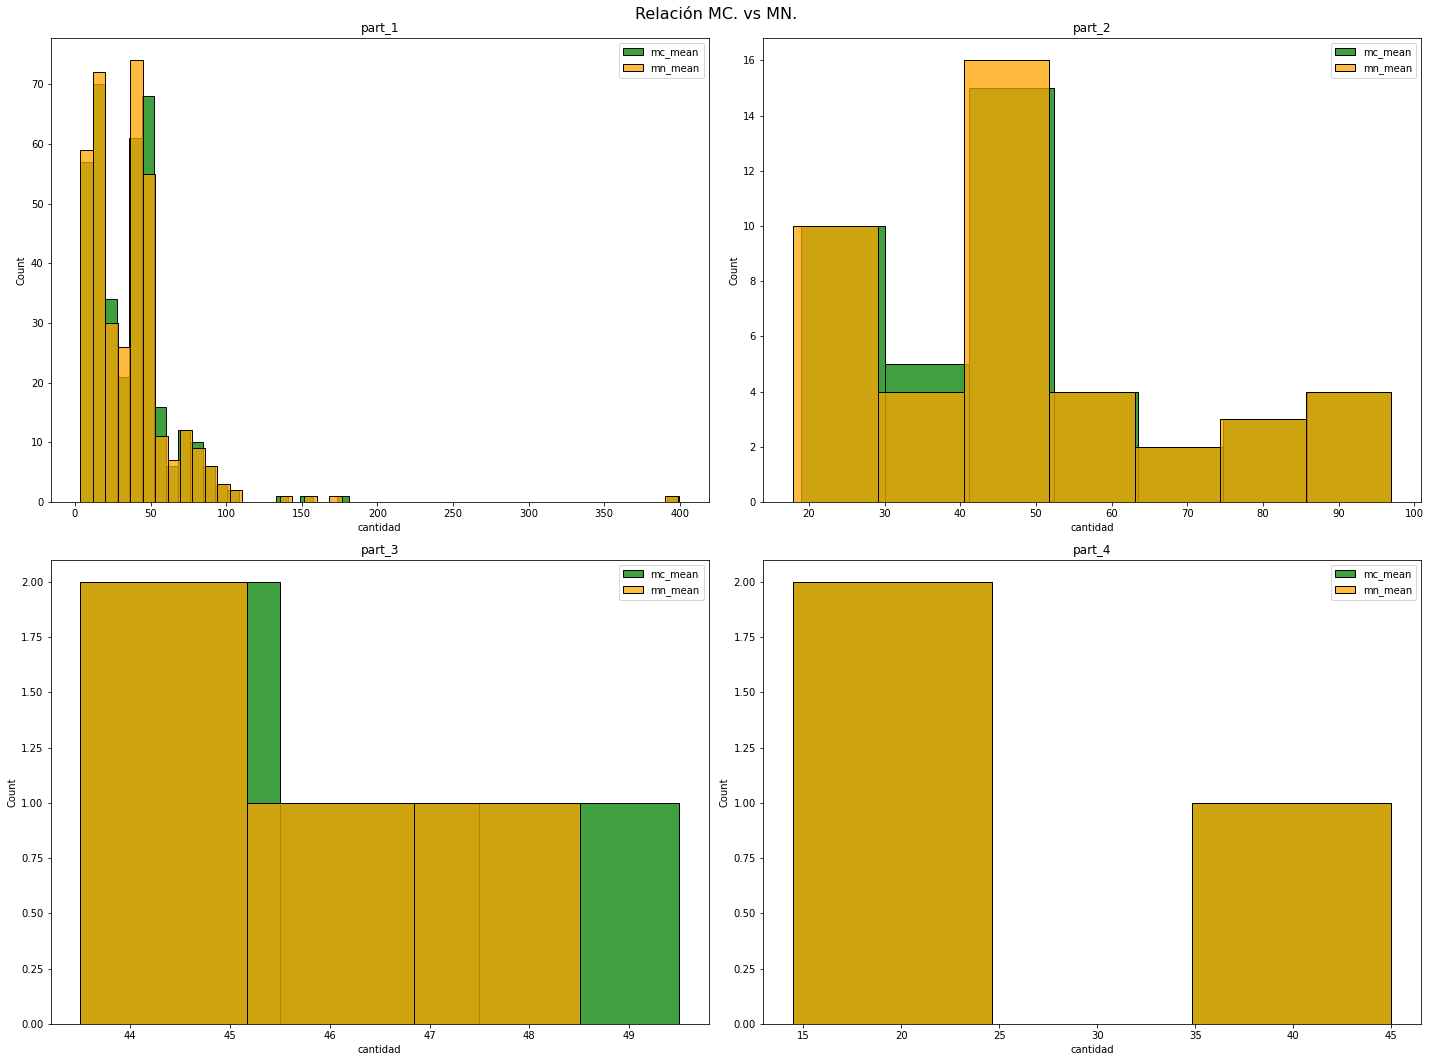

In [6]:
column_names = sorted(mc_and_mn.part.unique().tolist())

columnas = 2
renglones = math.ceil(len(column_names) / columnas)

fig, axes = plt.subplots(nrows = renglones, ncols = columnas, figsize=(20, 15))
fig.suptitle("Relación MC. vs MN.", fontsize = 16)

i = 0
j = 0
    
for col in column_names:
    ##for cumple in range (0, 2): ## Casos 0 y 1 de cumplimiento
    sns.histplot(data = mc_and_mn[mc_and_mn.part == col], x = 'mc_mean',
                 label = 'mc_mean',
                 ax = axes[i][j], multiple='layer', color='g')

    sns.histplot(data = mc_and_mn[mc_and_mn.part == col], x = 'mn_mean',
                 label = 'mn_mean',
                 ax = axes[i][j], multiple='layer', color='orange')
    
    axes[i][j].set_title(col)
    axes[i][j].set(xlabel="cantidad")
    axes[i][j].legend()
    
    j += 1
    if j > columnas - 1:
        i += 1
        j = 0

fig.tight_layout()        

Hasta acá es claro que la media de **Measure Number** y la media de **Measure Count** no tiene una clara tendencia, sino que más bien a veces uno es más grande que otro y viceversa.

### ¿Realmente los acordes son de 10 notas?
Es importante identificar si para cada tiempo tenemos la pulsación de 10 notas cómo máximo. Suponemos que cada conjunto de $n$-notas pulsadas en la misma posición relativa en el compás debe ser de 10 posiciones cuando más. Aquí lo vamos a comprobar.

In [7]:
n_notes_count = pd.DataFrame(columns=['filename', 'part',
                                  'staves',
                                  'max_n_notes'])
max_midi = 0

for filename in os.listdir(mscx_path):
    try:
        print('.', end = '')
        
        s = Score(mscx_path + '\\' + filename, read_only=True, logger_cfg = dict(level='CRITICAL'))

        for part in s.mscx.metadata['parts']:
            if s.mscx.metadata['parts'][part]['instrument'] == 'Piano':
                staves = s.mscx.metadata['parts'][part]['staves']
                piano_notes_rests = s.mscx.notes_and_rests[s.mscx.notes_and_rests.staff.isin(staves)]
                max_n_notes = piano_notes_rests.groupby(by=["mc", "mn_onset"]).count().max().midi
                n_notes_count.loc[len(n_notes_count.index)] = [filename, part, staves, max_n_notes]
                
    except:
        print('!', end = '')
        ##print('Error en el archivo: ', filename)

......

C:\Users\ismedina\Anaconda3\envs\MCDI2022_01_CompCognitivo\lib\site-packages\ms3\utils.py:1506: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mc_playthrough = pd.Series(seq, name='mc_playthrough')


...!....!.!............!.!...!.....!...!....!..!.!..!..!...............!..............!.......!...!.!........!.........!...!..!..!.!.!...!.!....!.!..!..!....!.!.....!......!.....!.....!......

C:\Users\ismedina\Anaconda3\envs\MCDI2022_01_CompCognitivo\lib\site-packages\ms3\utils.py:1506: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mc_playthrough = pd.Series(seq, name='mc_playthrough')


.!.!....

C:\Users\ismedina\Anaconda3\envs\MCDI2022_01_CompCognitivo\lib\site-packages\ms3\bs4_measures.py:709: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(result, name=name).reindex(df.index, fill_value=0)


.........!.....!.................

C:\Users\ismedina\Anaconda3\envs\MCDI2022_01_CompCognitivo\lib\site-packages\ms3\bs4_measures.py:709: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(result, name=name).reindex(df.index, fill_value=0)


..............!..!...!....!.!.!...!.......!......!.!.........!.!...!.!.!.!.!..!..!...!......!....!.!.!.!.!....!....!..

C:\Users\ismedina\Anaconda3\envs\MCDI2022_01_CompCognitivo\lib\site-packages\ms3\utils.py:1506: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mc_playthrough = pd.Series(seq, name='mc_playthrough')


.......!..!..!............!..

C:\Users\ismedina\Anaconda3\envs\MCDI2022_01_CompCognitivo\lib\site-packages\ms3\utils.py:1506: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mc_playthrough = pd.Series(seq, name='mc_playthrough')


.......!...!.!......!.!.......!.!.!....!...!.!..!...

C:\Users\ismedina\Anaconda3\envs\MCDI2022_01_CompCognitivo\lib\site-packages\ms3\utils.py:1506: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mc_playthrough = pd.Series(seq, name='mc_playthrough')


.........!........!.....!.!.!.!.!.!.!.!.!.!.!.!.!.!.!.!.!.!.!.!..!.!....!............!....!.!.!..........!..........!....!...!...!........!......!...!.!..!.!...!......!.!............!....!..!.....!.!...!.!.!.!..!..!.!.!.!.!.!..!.....!......!.!.!.!.!.!.......!.!...!.....!....!.!....!.!..!.......!....!...!.!..!.!.....!..!...!...!...................

C:\Users\ismedina\Anaconda3\envs\MCDI2022_01_CompCognitivo\lib\site-packages\ms3\utils.py:1506: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mc_playthrough = pd.Series(seq, name='mc_playthrough')


.....!.....!............

In [8]:
n_notes_count.to_csv('C:\\Users\\ismedina\\Documents\\Maestría\\2022-1\\SeminarioII\\n_notes_count.csv')

In [9]:
n_notes_count = pd.read_csv('C:\\Users\\ismedina\\Documents\\Maestría\\2022-1\\SeminarioII\\n_notes_count.csv', index_col = 0)

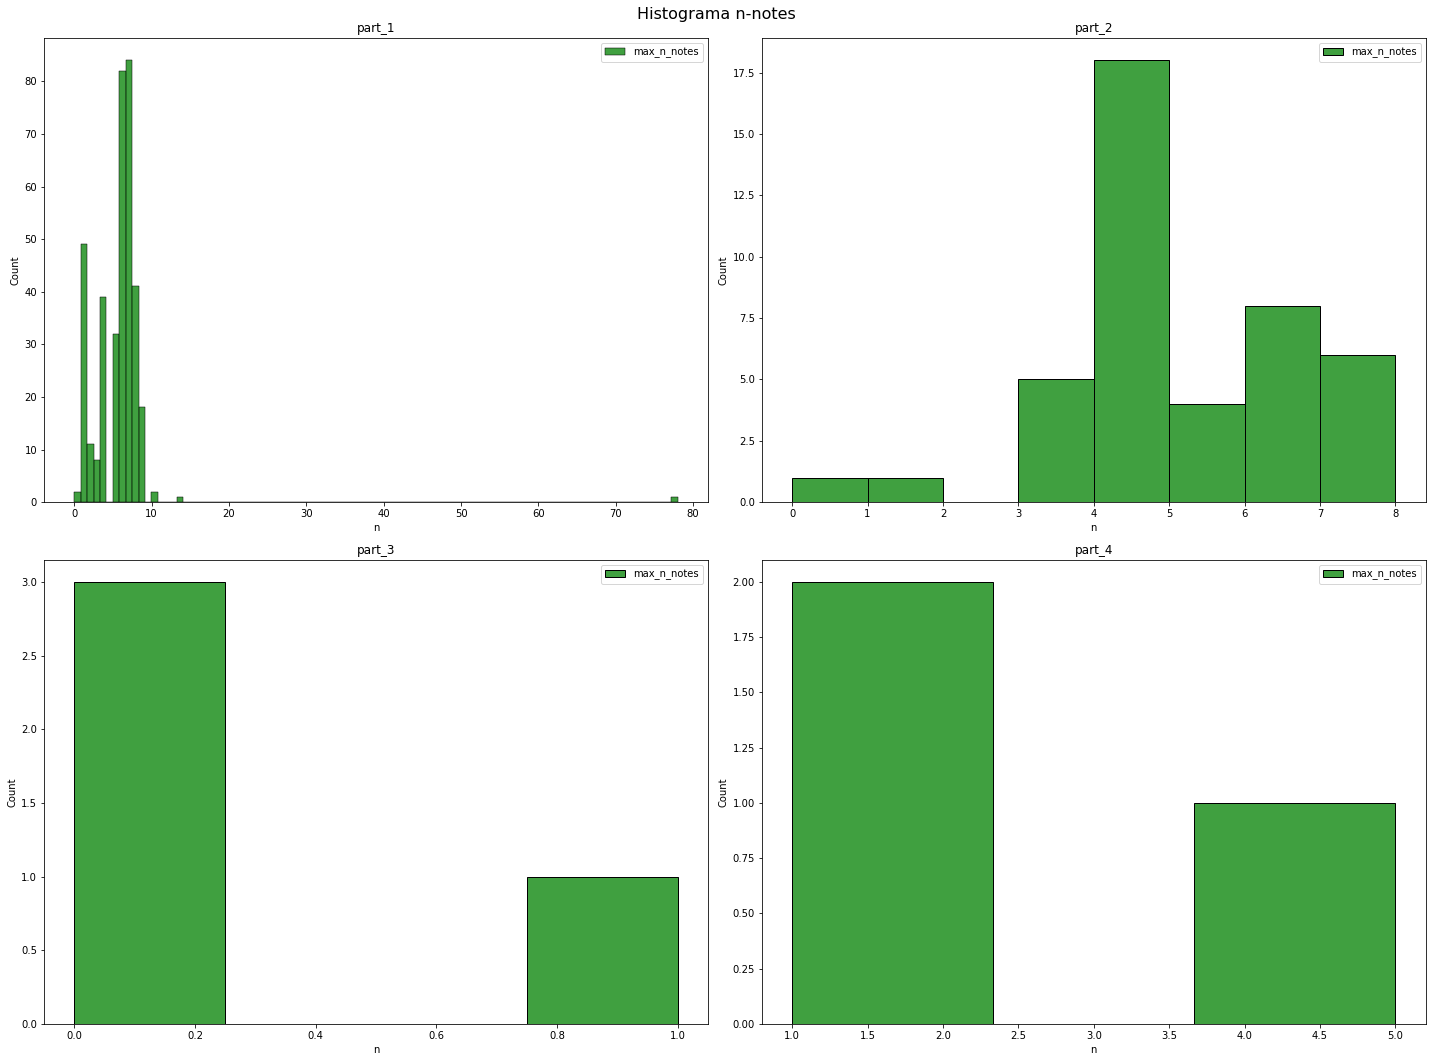

In [10]:
column_names = sorted(n_notes_count.part.unique().tolist())

columnas = 2
renglones = math.ceil(len(column_names) / columnas)

fig, axes = plt.subplots(nrows = renglones, ncols = columnas, figsize=(20, 15))
fig.suptitle("Histograma n-notes", fontsize = 16)

i = 0
j = 0
    
for col in column_names:
    sns.histplot(data = n_notes_count[n_notes_count.part == col], x = 'max_n_notes',
                 label = 'max_n_notes',
                 ax = axes[i][j], multiple='layer', color='green')

    axes[i][j].set_title(col)
    axes[i][j].set(xlabel="n")
    axes[i][j].legend()
    
    j += 1
    if j > columnas - 1:
        i += 1
        j = 0

fig.tight_layout()  

Se comprueba que, para un mismo tiempo en la partitura, hay una tendencia a pulsar 10 teclas o menos dado que el ejecutante tendrá este número máximo de dedos para la pulsación en el piano aun cuando hay casos extremos donde en un mismo tiempo se pulsan casi 80 notas.
Podemos entonces generar un Pandas DataFrame que contenga un registro con un índice numérico que describa grupos de $n$-notas con $0 \le n \le 10$. 

### Estadísticas de las duraciones de las notas
Para un trabajo posterior a desarrollar, resulta de interés el obtener las duraciones de las notas que conformarán el dataframe del mapa de conjuntos de $n$-notas. Para esto se usó el objeto `Parse`. Este objeto permite obtener información descriptiva de los archivos en una carpeta que, para nuestro caso, será el corpus.

In [11]:
from fractions import Fraction

mn_onset_count = pd.DataFrame(columns=['filename', 'part',
                                  'staff', 'duration', 'count'])

from fractions import Fraction

for filename in os.listdir(mscx_path):
    try:
        print('.', end = '')

        s = Score(mscx_path + '\\' + filename, read_only=True, logger_cfg = dict(level='CRITICAL'))

        for part in s.mscx.metadata['parts']:
            if s.mscx.metadata['parts'][part]['instrument'] == 'Piano':
                staves = s.mscx.metadata['parts'][part]['staves']

                mn_onsets = s.mscx.notes_and_rests[s.mscx.notes_and_rests.staff.isin(staves)].groupby(by = ['staff', 'duration']).count()
                for key, row in mn_onsets.iterrows():
                    mn_onset_count.loc[len(mn_onset_count.index)] = [filename, part, key[0], key[1], Fraction(row.mn)]                
    except:
        print('!', end = '')

......

C:\Users\ismedina\Anaconda3\envs\MCDI2022_01_CompCognitivo\lib\site-packages\ms3\utils.py:1506: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mc_playthrough = pd.Series(seq, name='mc_playthrough')


...!....!.!............!.!...!.....!...!....!..!.!..!..!...............!..............!.......!...!.!........!.........!...!..!..!.!.!...!.!....!.!..!..!....!.!.....!......!.....!.....!......

C:\Users\ismedina\Anaconda3\envs\MCDI2022_01_CompCognitivo\lib\site-packages\ms3\utils.py:1506: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mc_playthrough = pd.Series(seq, name='mc_playthrough')


.!.!....

C:\Users\ismedina\Anaconda3\envs\MCDI2022_01_CompCognitivo\lib\site-packages\ms3\bs4_measures.py:709: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(result, name=name).reindex(df.index, fill_value=0)


.........!.....!.................

C:\Users\ismedina\Anaconda3\envs\MCDI2022_01_CompCognitivo\lib\site-packages\ms3\bs4_measures.py:709: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(result, name=name).reindex(df.index, fill_value=0)


..............!..!...!....!.!.!...!.......!......!.!.........!.!...!.!.!.!.!..!..!...!......!....!.!.!.!.!....!....!..

C:\Users\ismedina\Anaconda3\envs\MCDI2022_01_CompCognitivo\lib\site-packages\ms3\utils.py:1506: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mc_playthrough = pd.Series(seq, name='mc_playthrough')


.......!..!..!............!..

C:\Users\ismedina\Anaconda3\envs\MCDI2022_01_CompCognitivo\lib\site-packages\ms3\utils.py:1506: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mc_playthrough = pd.Series(seq, name='mc_playthrough')


.......!...!.!......!.!.......!.!.!....!...!.!..!...

C:\Users\ismedina\Anaconda3\envs\MCDI2022_01_CompCognitivo\lib\site-packages\ms3\utils.py:1506: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mc_playthrough = pd.Series(seq, name='mc_playthrough')


.........!........!.....!.!.!.!.!.!.!.!.!.!.!.!.!.!.!.!.!.!.!.!..!.!....!............!....!.!.!..........!..........!....!...!...!........!......!...!.!..!.!...!......!.!............!....!..!.....!.!...!.!.!.!..!..!.!.!.!.!.!..!.....!......!.!.!.!.!.!.......!.!...!.....!....!.!....!.!..!.......!....!...!.!..!.!.....!..!...!...!...................

C:\Users\ismedina\Anaconda3\envs\MCDI2022_01_CompCognitivo\lib\site-packages\ms3\utils.py:1506: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mc_playthrough = pd.Series(seq, name='mc_playthrough')


.....!.....!............

In [12]:
mn_onset_count.to_csv('C:\\Users\\ismedina\\Documents\\Maestría\\2022-1\\SeminarioII\\mn_onset_count.csv')

In [13]:
mn_onset_count = pd.read_csv('C:\\Users\\ismedina\\Documents\\Maestría\\2022-1\\SeminarioII\\mn_onset_count.csv', index_col = 0)

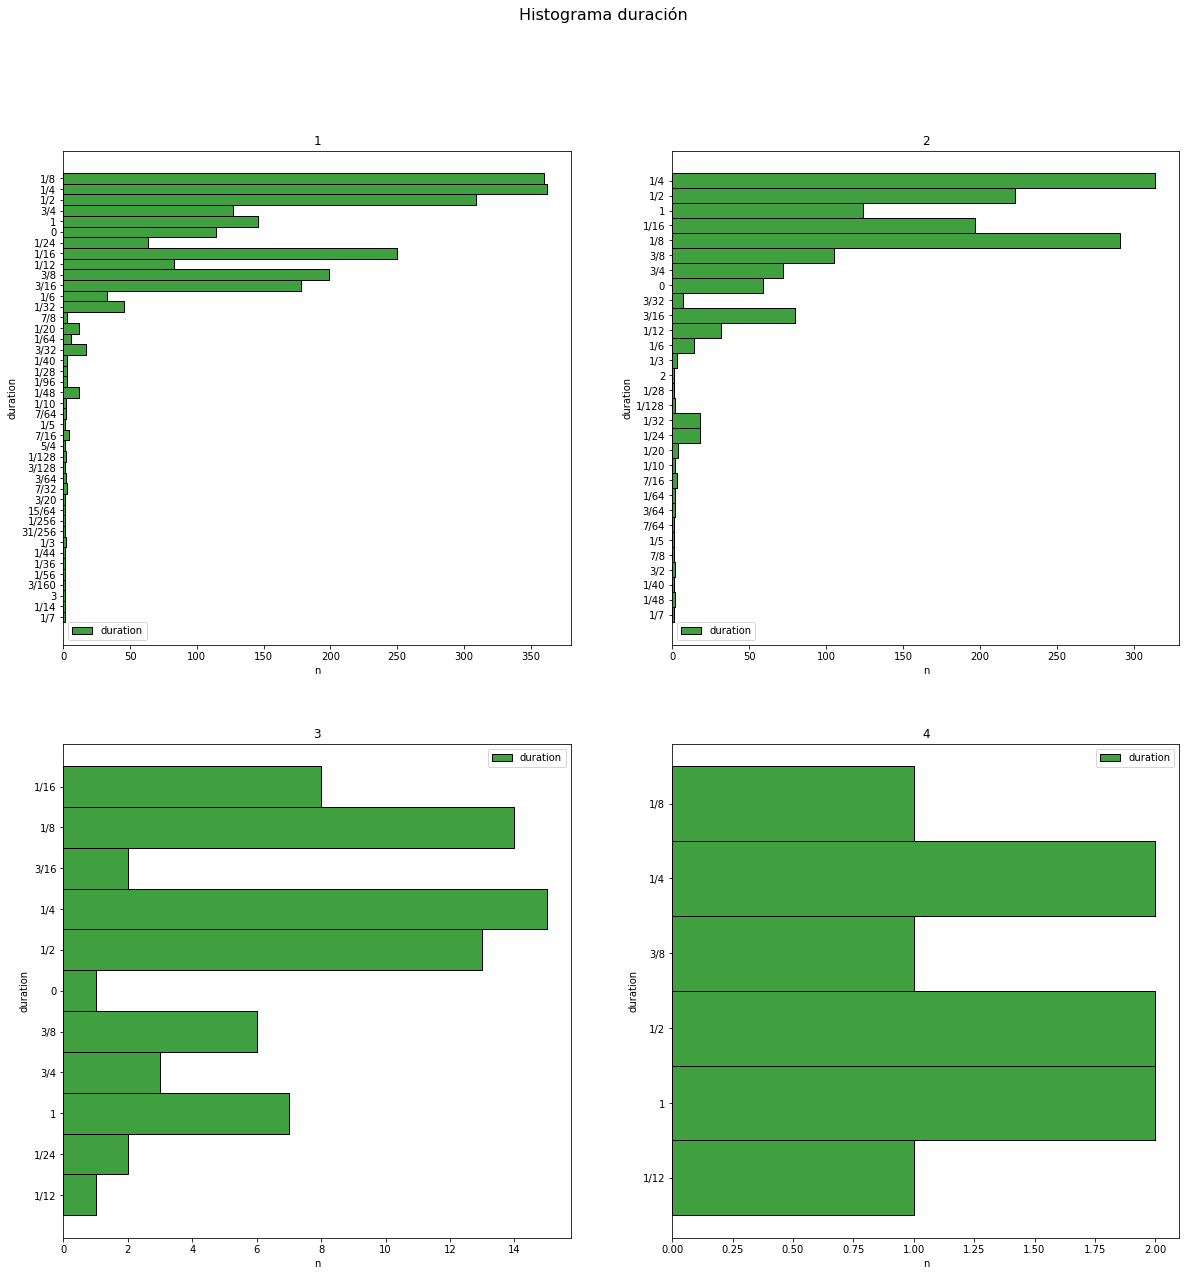

In [14]:
column_names = sorted(mn_onset_count.staff.unique().tolist())

columnas = 2
renglones = math.ceil(len(column_names) / columnas)

fig, axes = plt.subplots(nrows = renglones, ncols = columnas, figsize=(20, 20))
fig.suptitle("Histograma duración", fontsize = 16)

i = 0
j = 0
    
for col in column_names:
    sns.histplot(data = mn_onset_count[mn_onset_count.staff == col], y = 'duration',
                 label = 'duration',
                 ax = axes[i][j], multiple='layer', color='green')

    axes[i][j].set_title(col)
    axes[i][j].set(xlabel="n")
    axes[i][j].legend()
    
    j += 1
    if j > columnas - 1:
        i += 1
        j = 0

##fig.tight_layout()  

Se puede concluir hasta aquí que los tiempos binarios son predominantes mientras que hay unos pocos ternarios y que las duraciones bajas no son comunes. Las fusas serían un límite conveniente de la duración de las notas para excluirlas del corpus.

## Extracción de acordes
Una vez que se exploró el conjunto de datos entonces se generó entonces un mapa de conjuntos de $n$-notas pulsadas en el mismo tiempo que es posible encontrar en cada partitura. El índice del Pandas DataFrame resultante será el identificador (id) del conjunto único de $n$-notas que se usará posteriormente para describir el siguiente conjunto de $n$-notas posterior a una combinación de conjuntos de $n$-notas precedentes.

In [15]:
n_notes = pd.DataFrame(columns=['note01', 'note02', 'note03'
                              ,'note04', 'note05', 'note06'
                              ,'note07', 'note08', 'note09'
                              ,'note10'], dtype= int)

notes = []
n_note = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
n_notes.loc[len(n_notes.index)] = n_note

for filename in os.listdir(mscx_path):
    try:
        print('.', end = '')

        s = Score(mscx_path + '\\' + filename, read_only=True, logger_cfg = dict(level='CRITICAL'))

        for part in s.mscx.metadata['parts']:
            if s.mscx.metadata['parts'][part]['instrument'] == 'Piano':
                staves = s.mscx.metadata['parts'][part]['staves']
                piano_notes_rests = s.mscx.notes_and_rests[s.mscx.notes_and_rests.staff.isin(staves)]

                previous_position = piano_notes_rests.iloc[0]['mn_onset']

                for idx, row in piano_notes_rests.iterrows():
                    note = row['midi'] 

                    if row['mn_onset'] == previous_position:
                        if not pd.isna(note):
                            notes.append(note)
                    else:
                        previous_position = row['mn_onset']
                        unique_notes = sorted(list(set(notes)))

                        i = 0

                        for unique_note in unique_notes[:10]:
                            n_note[i] = unique_note
                            i += 1

                        n_notes.loc[len(n_notes.index)] = n_note
                        if not pd.isna(note):
                            notes = [note]
                        else:
                            notes = []
                        n_note = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]                    
    except:
        print('!', end = '')
        ##print('Error en el archivo: ', filename)

......

C:\Users\ismedina\Anaconda3\envs\MCDI2022_01_CompCognitivo\lib\site-packages\ms3\utils.py:1506: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mc_playthrough = pd.Series(seq, name='mc_playthrough')


...!....!.!............!.!...!.....!...!....!..!.!..!..!...............!..............!.......!...!.!........!.........!...!..!..!.!.!...!.!....!.!..!..!....!.!.....!......!.....!.....!......

C:\Users\ismedina\Anaconda3\envs\MCDI2022_01_CompCognitivo\lib\site-packages\ms3\utils.py:1506: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mc_playthrough = pd.Series(seq, name='mc_playthrough')


.!.!....

C:\Users\ismedina\Anaconda3\envs\MCDI2022_01_CompCognitivo\lib\site-packages\ms3\bs4_measures.py:709: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(result, name=name).reindex(df.index, fill_value=0)


.........!.....!.................

C:\Users\ismedina\Anaconda3\envs\MCDI2022_01_CompCognitivo\lib\site-packages\ms3\bs4_measures.py:709: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(result, name=name).reindex(df.index, fill_value=0)


..............!..!...!....!.!.!...!.......!......!.!.........!.!...!.!.!.!.!..!..!...!......!....!.!.!.!.!....!....!..

C:\Users\ismedina\Anaconda3\envs\MCDI2022_01_CompCognitivo\lib\site-packages\ms3\utils.py:1506: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mc_playthrough = pd.Series(seq, name='mc_playthrough')


.......!..!..!............!..

C:\Users\ismedina\Anaconda3\envs\MCDI2022_01_CompCognitivo\lib\site-packages\ms3\utils.py:1506: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mc_playthrough = pd.Series(seq, name='mc_playthrough')


.......!...!.!......!.!.......!.!.!....!...!.!..!...

C:\Users\ismedina\Anaconda3\envs\MCDI2022_01_CompCognitivo\lib\site-packages\ms3\utils.py:1506: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mc_playthrough = pd.Series(seq, name='mc_playthrough')


.........!........!.....!.!.!.!.!.!.!.!.!.!.!.!.!.!.!.!.!.!.!.!..!.!....!............!....!.!.!..........!..........!....!...!...!........!......!...!.!..!.!...!......!.!............!....!..!.....!.!...!.!.!.!..!..!.!.!.!.!.!..!.....!......!.!.!.!.!.!.......!.!...!.....!....!.!....!.!..!.......!....!...!.!..!.!.....!..!...!...!...................

C:\Users\ismedina\Anaconda3\envs\MCDI2022_01_CompCognitivo\lib\site-packages\ms3\utils.py:1506: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mc_playthrough = pd.Series(seq, name='mc_playthrough')


.....!.....!............

In [16]:
master_n_notes = n_notes.drop_duplicates()

In [17]:
len(master_n_notes), len(n_notes)

(16757, 186380)

In [18]:
master_n_notes.reset_index(drop = True, inplace = True)

In [19]:
master_n_notes.head()

,note01,note02,note03,note04,note05,note06,note07,note08,note09,note10
0,0,0,0,0,0,0,0,0,0,0
1,41,52,55,57,60,0,0,0,0,0
2,69,0,0,0,0,0,0,0,0,0
3,44,50,59,64,67,0,0,0,0,0
4,65,0,0,0,0,0,0,0,0,0


In [20]:
master_n_notes.to_csv('C:\\Users\\ismedina\\Documents\\Maestría\\2022-1\\SeminarioII\\master_n_notes.csv')

## Secuencias de acordes
Con el trabajo anterior de codificar cada conjunto de $n$-notas es ahora posible generar la codificación de una secuencia de $n$-notas. En este caso se codificaron secuencias de 3 $n$-notas. El detalle de la codificación se encuentra a continuación.

In [21]:
master_n_notes = pd.read_csv('C:\\Users\\ismedina\\Documents\\Maestría\\2022-1\\SeminarioII\\master_n_notes.csv', index_col = 0)

In [22]:
master_n_notes.head(10)

,note01,note02,note03,note04,note05,note06,note07,note08,note09,note10
0,0,0,0,0,0,0,0,0,0,0
1,41,52,55,57,60,0,0,0,0,0
2,69,0,0,0,0,0,0,0,0,0
3,44,50,59,64,67,0,0,0,0,0
4,65,0,0,0,0,0,0,0,0,0
5,43,53,57,58,60,0,0,0,0,0
6,48,52,0,0,0,0,0,0,0,0
7,60,0,0,0,0,0,0,0,0,0
8,46,57,60,62,67,0,0,0,0,0
9,45,55,59,60,62,0,0,0,0,0


La siguiente función permite identificar el id del $n$-notas de entrada dentro del conjunto completo.

In [23]:
def get_n_notes_id (n_notes):
    id = master_n_notes.loc[(master_n_notes.note01 == n_notes[0]) &
                         (master_n_notes.note02 == n_notes[1]) &
                         (master_n_notes.note03 == n_notes[2]) &
                         (master_n_notes.note04 == n_notes[3]) &
                         (master_n_notes.note05 == n_notes[4]) &
                         (master_n_notes.note06 == n_notes[5]) &
                         (master_n_notes.note07 == n_notes[6]) &
                         (master_n_notes.note08 == n_notes[7]) &
                         (master_n_notes.note09 == n_notes[8]) &
                         (master_n_notes.note10 == n_notes[9])].index[0]
    return id

In [24]:
n_notes_sequences = pd.DataFrame(columns=['prev_n_notes_id', 'actual_n_notes_id', 'next_n_notes_id'], dtype= int)

notes = []
n_notes = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
previous_n_notes = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
actual_n_notes = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
next_n_notes = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

for filename in os.listdir(mscx_path):
    try:
        print('.', end = '')

        s = Score(mscx_path + '\\' + filename, read_only=True, logger_cfg = dict(level='CRITICAL'))

        sequence_step = 1
        for part in s.mscx.metadata['parts']:
            if s.mscx.metadata['parts'][part]['instrument'] == 'Piano':
                staves = s.mscx.metadata['parts'][part]['staves']
                piano_notes_rests = s.mscx.notes_and_rests[s.mscx.notes_and_rests.staff.isin(staves)]

                previous_position = piano_notes_rests.iloc[0]['mn_onset']

                for idx, row in piano_notes_rests.iterrows():
                    note = row['midi'] 

                    if row['mn_onset'] == previous_position:
                        if not pd.isna(note):
                            notes.append(note)
                    else:
                        previous_position = row['mn_onset']
                        unique_notes = sorted(list(set(notes)))

                        i = 0
                        for unique_note in unique_notes[:10]:
                            n_notes[i] = unique_note
                            i += 1

                        if sequence_step == 1:
                            actual_n_notes = n_notes
                            sequence_step += 1

                        if sequence_step == 2:
                            next_n_notes = n_notes

                            previous_n_notes_id = get_n_notes_id(previous_n_notes)
                            actual_n_notes_id = get_n_notes_id(actual_n_notes)
                            next_n_notes_id = get_n_notes_id(next_n_notes)

                            n_notes_sequences.loc[len(n_notes_sequences.index)] = [previous_n_notes_id, 
                                                                                   actual_n_notes_id,
                                                                                   next_n_notes_id]

                            previous_n_notes = actual_n_notes.copy()
                            actual_n_notes = next_n_notes.copy()

                        n_notes = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   

                        if not pd.isna(note):
                            notes = [note]
                        else:
                            notes = []

        previous_n_notes_id = get_n_notes_id(previous_n_notes)
        actual_n_notes_id = get_n_notes_id(actual_n_notes)
        next_n_notes_id = get_n_notes_id(n_notes)

        n_notes_sequences.loc[len(n_notes_sequences.index)] = [previous_n_notes_id, 
                                                               actual_n_notes_id,
                                                               next_n_notes_id]
    except:
        print('!', end = '')

......

C:\Users\ismedina\Anaconda3\envs\MCDI2022_01_CompCognitivo\lib\site-packages\ms3\utils.py:1506: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mc_playthrough = pd.Series(seq, name='mc_playthrough')


...!....!.!............!.!...!.....!...!....!..!.!..!..!...............!..............!.......!...!.!........!.........!...!..!..!.!.!...!.!....!.!..!..!....!.!.....!......!.....!.....!......

C:\Users\ismedina\Anaconda3\envs\MCDI2022_01_CompCognitivo\lib\site-packages\ms3\utils.py:1506: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mc_playthrough = pd.Series(seq, name='mc_playthrough')


.!.!....

C:\Users\ismedina\Anaconda3\envs\MCDI2022_01_CompCognitivo\lib\site-packages\ms3\bs4_measures.py:709: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(result, name=name).reindex(df.index, fill_value=0)


.........!.....!.................

C:\Users\ismedina\Anaconda3\envs\MCDI2022_01_CompCognitivo\lib\site-packages\ms3\bs4_measures.py:709: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(result, name=name).reindex(df.index, fill_value=0)


..............!..!...!....!.!.!...!.......!......!.!.........!.!...!.!.!.!.!..!..!...!......!....!.!.!.!.!....!....!..

C:\Users\ismedina\Anaconda3\envs\MCDI2022_01_CompCognitivo\lib\site-packages\ms3\utils.py:1506: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mc_playthrough = pd.Series(seq, name='mc_playthrough')


.......!..!..!............!..

C:\Users\ismedina\Anaconda3\envs\MCDI2022_01_CompCognitivo\lib\site-packages\ms3\utils.py:1506: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mc_playthrough = pd.Series(seq, name='mc_playthrough')


.......!...!.!......!.!.......!.!.!....!...!.!..!...

C:\Users\ismedina\Anaconda3\envs\MCDI2022_01_CompCognitivo\lib\site-packages\ms3\utils.py:1506: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mc_playthrough = pd.Series(seq, name='mc_playthrough')


.........!........!.....!.!.!.!.!.!.!.!.!.!.!.!.!.!.!.!.!.!.!.!..!.!....!............!....!.!.!..........!..........!....!...!...!........!......!...!.!..!.!...!......!.!............!....!..!.....!.!...!.!.!.!..!..!.!.!.!.!.!..!.....!......!.!.!.!.!.!.......!.!...!.....!....!.!....!.!..!.......!....!...!.!..!.!.....!..!...!...!...................

C:\Users\ismedina\Anaconda3\envs\MCDI2022_01_CompCognitivo\lib\site-packages\ms3\utils.py:1506: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mc_playthrough = pd.Series(seq, name='mc_playthrough')


.....!.....!............

In [25]:
unique_n_notes_sequences = n_notes_sequences.drop_duplicates()

In [26]:
unique_n_notes_sequences.reset_index(drop = True, inplace = True)

In [27]:
len(unique_n_notes_sequences), len(n_notes_sequences)

(85764, 186842)

In [28]:
unique_n_notes_sequences.to_csv('C:\\Users\\ismedina\\Documents\\Maestría\\2022-1\\SeminarioII\\unique_n_notes_sequences.csv')

## Entrenamiento de la red neuronal
Con los datos ya codificados entonces fue posible hacer el entrenamiento de la red neuronal, sin embargo, el paso anterior es la creación de los tensores de entrada. 

### Los tensores de entrada
La definición de los tensores de entrada se realizó tomando como guía el trabajo de Ijas(2019). Este trabajo muestra la predicción de la siguiente palabra dada una secuencia de palabras previas. Es así que se generó una cantidad de $m$ vectores que representan el *One-Hot encoding* para las secuencias de $n$-notas. En este caso, los $m$ vectores son $3$.

In [41]:
import numpy as np
import pandas as pd
import tensorflow as tf
import heapq
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM, GRU
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import plot_model

In [42]:
unique_n_notes_sequences = pd.read_csv('C:\\Users\\ismedina\\Documents\\Maestría\\2022-1\\SeminarioII\\unique_n_notes_sequences.csv', index_col = 0)

In [43]:
master_n_notes = pd.read_csv('C:\\Users\\ismedina\\Documents\\Maestría\\2022-1\\SeminarioII\\master_n_notes.csv', index_col = 0)

Así entonces definimos $\mathbb{x}$ tiene la forma de todos los `unique_n_notes_sequences` $ \times $ `2 conjuntos de n-notas` $ \times $ `cantidad de id's distintos` mientras que $\mathbb{y}$ es un vector donde el `id` del acorde más probable se registra.

In [44]:
x = np.zeros((unique_n_notes_sequences.shape[0], unique_n_notes_sequences.shape[1] - 1, master_n_notes.shape[0]), dtype=bool)
y = np.zeros((unique_n_notes_sequences.shape[0], master_n_notes.shape[0]), dtype=bool)

for key, row in unique_n_notes_sequences.iterrows():
    x[key, 0, row[0]] = 1
    x[key, 1, row[1]] = 1
    y[key, row[2]] = 1

### Modelo 1. La red neuronal recurrente (RNN) con LSTM
La red neuronal que se construyó para el proyecto es una RNN con una capa `Long Short-Term Memory (LSTM)` que recibe los 2 tensores de *One-Hot encoding* de cada `id` de $n$-notas en las secuencias. La activación de hace por `softmax`a fin de regresar la probabilidad de los `id` calculados dado el tensor de entrada. Se anexa el código donde se muestra la forma gráfica de la red neuronal profunda.

In [45]:
modelLSTM = Sequential()
modelLSTM.add(LSTM(512, input_shape = (x.shape[1:])))
modelLSTM.add(Dense(master_n_notes.shape[0]))
modelLSTM.add(Activation('softmax'))

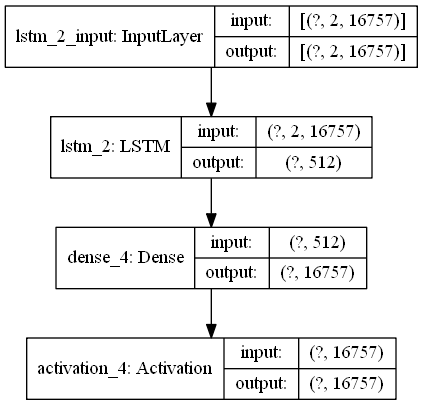

In [46]:
plot_model(modelLSTM, show_shapes = True, 
           show_layer_names = True)

In [47]:
optimizer = RMSprop(lr=0.01)
modelLSTM.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = modelLSTM.fit(x, y, validation_split=0.05, batch_size=128, epochs=2, shuffle=True).history

Train on 81475 samples, validate on 4289 samples
Epoch 1/2
81475/81475 [==============================] - 603s 7ms/sample - loss: 7.6168 - accuracy: 0.0437 - val_loss: 7.7844 - val_accuracy: 0.0485
Epoch 2/2
81475/81475 [==============================] - 629s 8ms/sample - loss: 7.0921 - accuracy: 0.0651 - val_loss: 8.1307 - val_accuracy: 0.0490


### Modelo 2. La red neuronal recurrente (RNN) con GRU
La red neuronal que se construyó para el proyecto es una RNN con una capa `Gated Recurrent Unit (GRU)` que recibe los 2 tensores de *One-Hot encoding* de cada `id` de $n$-notas en las secuencias. La activación de hace por `softmax`a fin de regresar la probabilidad de los `id` calculados dado el tensor de entrada. Se anexa el código donde se muestra la forma gráfica de la red neuronal profunda.

In [48]:
modelGRU = Sequential()
modelGRU.add(GRU(512, input_shape = (x.shape[1:])))
modelGRU.add(Dense(master_n_notes.shape[0]))
modelGRU.add(Activation('softmax'))

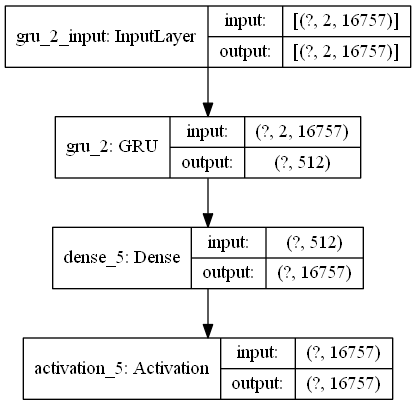

In [49]:
plot_model(modelGRU, show_shapes = True, 
           show_layer_names = True)

In [50]:
optimizer = RMSprop(lr=0.01)
modelGRU.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = modelGRU.fit(x, y, validation_split=0.05, batch_size=128, epochs=2, shuffle=True).history

Train on 81475 samples, validate on 4289 samples
Epoch 1/2
81475/81475 [==============================] - 452s 6ms/sample - loss: 7.5865 - accuracy: 0.0478 - val_loss: 7.7602 - val_accuracy: 0.0541
Epoch 2/2
81475/81475 [==============================] - 497s 6ms/sample - loss: 6.9969 - accuracy: 0.0825 - val_loss: 8.4504 - val_accuracy: 0.0478


# Presentación de resultados
A continuación, se mostrarán los resultados del `accuracy` de los modelos entrenados.

## Comparación de las soluciones propuestas
Observando los resultados debajo decimos que la RNN con la capa GRU tuvo un mejor desempeño si observamos el `accuracy` del conjunto de validación. Es por esto que decimos que el modelo `modelLSTM` lo hizo mejor que el modelo `modelGRU`.

In [51]:
print("LSTM val_accuracy:", modelLSTM.metrics[0].result().numpy())
print("GRU  val_accuracy:", modelGRU.metrics[0].result().numpy())

LSTM val_accuracy: 0.048962463
GRU  val_accuracy: 0.04779669


## Resultados con la mejor solución al problema
### Los tensores resultantes
Para comprobar la generación de la secuencia de $n$-notas se toma un tensor aleatorio de 2 $n$-notas. Vamos a tomar el acorde nuevo para que forme parte del nuevo tensor de predicción.

In [52]:
top_n = 1
n_notes_id_sequences = pd.DataFrame(columns=['n_notes_01', 'n_notes_02', 'n_notes_03',
                                 'n_notes_04', 'n_notes_05', 'n_notes_06',
                                 'n_notes_07', 'n_notes_08',
                                            'n_notes_09', 'n_notes_10', 'n_notes_11',
                                 'n_notes_12', 'n_notes_13', 'n_notes_14',
                                 'n_notes_15', 'n_notes_16'], dtype= int)

for sequence in range(5):
    input_n_notes = x[np.random.choice(range(len(x)), size=1)[0]]
    oh_n_notes_sequence = input_n_notes.copy()
    n_notes_id = []

    for i in range(14):
        new_prediction = modelLSTM.predict(np.expand_dims(oh_n_notes_sequence[-2:], axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        log_prediction = np.log(new_prediction)
        exp_prediction = np.exp(log_prediction)
        prediction = exp_prediction / np.sum(exp_prediction)

        n_notes_index = heapq.nlargest(top_n, range(len(prediction)), prediction.take)
        to_append = np.zeros((1, master_n_notes.shape[0]), dtype=bool)
        to_append[0][n_notes_index] = True

        oh_n_notes_sequence = np.concatenate([oh_n_notes_sequence, to_append])
    
    for oh_n_notes in oh_n_notes_sequence:
        n_notes_id.append(oh_n_notes.argmax())
        
    n_notes_id_sequences.loc[len(n_notes_id_sequences.index)] = n_notes_id

In [53]:
n_notes_id_sequences.to_csv('C:\\Users\\ismedina\\Documents\\Maestría\\2022-1\\SeminarioII\\n_notes_id_sequences.csv')

### La música resultante
Con las predicciones hechas ya es posible generar las partituras y midis asociados a los compases propuestos para la asistencia en la creación musical. Las celdas a continuación generan dichos elementos.

In [29]:
import numpy as np
import pandas as pd
import music21
from music21 import *

## Variables de entorno donde se encuentra el binario de MuseScore
us = environment.UserSettings()
us['musicxmlPath'] = 'C:\\Program Files\\MuseScore 3\\bin\\MuseScore3.exe'
us['musescoreDirectPNGPath'] = 'C:\\Program Files\\MuseScore 3\\bin\\MuseScore3.exe'
us['musicxmlPath']

WindowsPath('C:/Program Files/MuseScore 3/bin/MuseScore3.exe')

In [30]:
n_notes_id_sequences = pd.read_csv('C:\\Users\\ismedina\\Documents\\Maestría\\2022-1\\SeminarioII\\n_notes_id_sequences.csv', index_col = 0)
master_n_notes = pd.read_csv('C:\\Users\\ismedina\\Documents\\Maestría\\2022-1\\SeminarioII\\master_n_notes.csv', index_col = 0)

In [31]:
n_notes_id_sequences

,n_notes_01,n_notes_02,n_notes_03,n_notes_04,n_notes_05,n_notes_06,n_notes_07,n_notes_08,n_notes_09,n_notes_10,n_notes_11,n_notes_12,n_notes_13,n_notes_14,n_notes_15,n_notes_16
0,416,12,78,12,78,12,78,12,78,12,78,12,78,12,78,12
1,1248,105,681,681,681,681,681,681,681,681,681,681,681,681,681,681
2,1254,609,1254,1254,1254,1254,1254,1254,1254,1254,1254,1254,1254,1254,1254,1254
3,5928,96,653,692,653,692,653,692,653,692,653,692,653,692,653,692
4,153,7392,153,153,153,153,153,153,153,153,153,153,153,153,153,153


Partitura 0


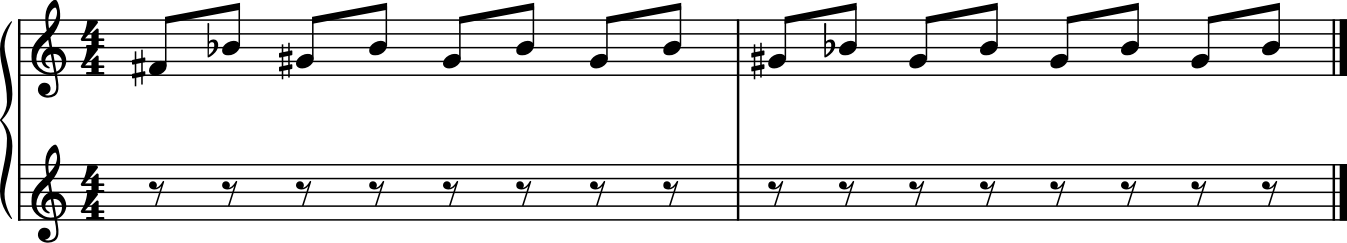

Partitura 1


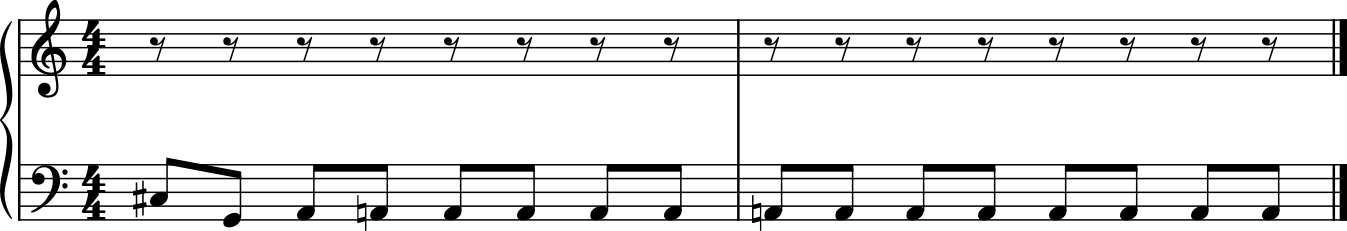

Partitura 2


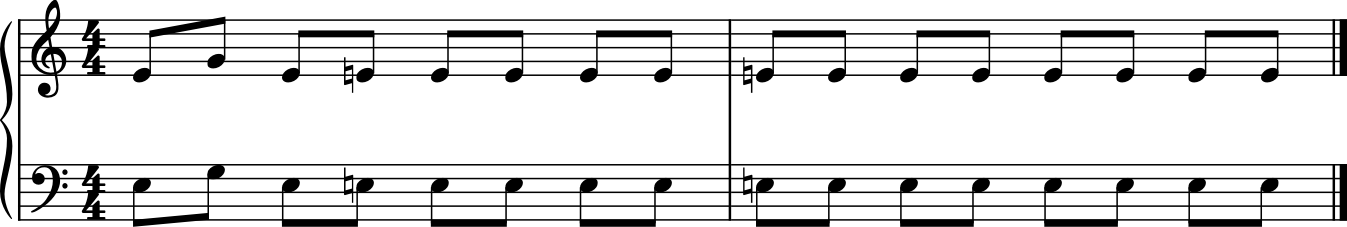

Partitura 3


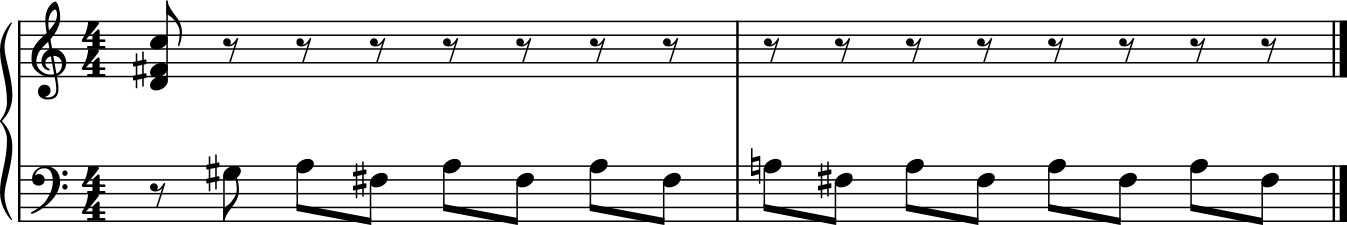

Partitura 4


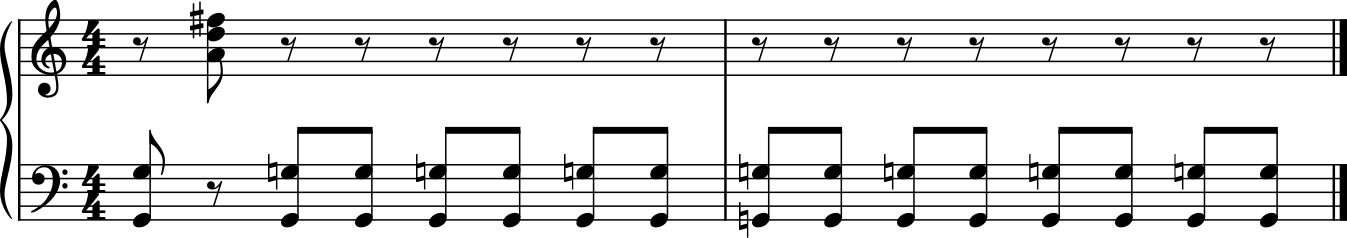

In [32]:
columns = n_notes_id_sequences.columns

for key, row in n_notes_id_sequences.iterrows():
    filename =  'C:\\Users\\ismedina\\Documents\\Maestría\\2022-1\\SeminarioII\\Partitura' + str(key) + '.mid'
    print('Partitura %d' % key)
    s = stream.Score()
    sequence_staff_C = []
    sequence_staff_F = []
    staff_C = stream.Part()
    staff_F = stream.Part()
    for column in columns:
        n_notes = master_n_notes.loc[row[column]]
        
        if np.count_nonzero(n_notes) == 0:
            sequence_staff_C.append(note.Rest(type='eighth'))
            sequence_staff_F.append(note.Rest(type='eighth'))
        elif np.count_nonzero(n_notes) == 1:
            if n_notes[0] > 0 and n_notes[0] < 60:
                sequence_staff_F.append(note.Note(n_notes[0], type='eighth'))
                sequence_staff_C.append(note.Rest(type='eighth'))
            if n_notes[0] >= 60:
                sequence_staff_C.append(note.Note(n_notes[0], type='eighth'))
                sequence_staff_F.append(note.Rest(type='eighth'))
        else:
            c_staff_C = []
            c_staff_F = []
            for n_note in n_notes[:np.count_nonzero(n_notes)]:
                if n_note > 0 and n_note < 60:
                    c_staff_F.append(note.Note(n_note, type='eighth'))
                if n_note >= 60:
                    c_staff_C.append(note.Note(n_note, type='eighth'))
            
            if len(c_staff_C) > 0:
                sequence_staff_C.append(chord.Chord(c_staff_C, type='eighth'))
            else:
                sequence_staff_C.append(note.Rest(type='eighth'))

            if len(c_staff_F) > 0:
                sequence_staff_F.append(chord.Chord(c_staff_F, type='eighth'))
            else:
                sequence_staff_F.append(note.Rest(type='eighth'))
    
    ##print(sequence_staff_C)
    staff_C.append(sequence_staff_C)
    staff_F.append(sequence_staff_F)
    
    s.insert(0, staff_C)
    s.insert(0, staff_F)            

    staffGroup1 = layout.StaffGroup([staff_C, staff_F],
                                    name='Piano', abbreviation='Piano', symbol='brace')
    staffGroup1.barTogether = 'Mensurstrich'
    s.insert(0, staffGroup1)
    s.show()
    s.show('midi')
    s.write('midi', fp=filename)


# Referencias

* Briot, J. (2021). From artificial neural networks to deep learning for music generation: history, concepts and trends. *Neural Comput & Applic 33*, 36-65.
* Ijas, A. H. (2 de Noviembre de 2019). *Build a simple predictive keyboard using python and Keras*. Obtenido de medium.com: https://medium.com/analytics-vidhya/build-a-simple-predictive-keyboard-using-python-and-keras-b78d3c88cffb
* Lozano Cruz, O. S.-G. (6 de Junio de 2013). El cerebro y la música. *Rev Med UV, Enero - Junio 2013*, págs. 17-22.
* Morán Martínez, M. C. (1 de Noviembre de 2009). Psicología y Música: inteligencia musical y desarrollo estético*. *Revista Digital Universitaria*, págs. 1-13.

